In [103]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from keras.layers import Embedding, LSTM, Dropout, Dense, GRU, SimpleRNN, Flatten


In [63]:
df = pd.read_csv('data/data.csv', quotechar='"')

In [64]:
texts = df['text'].astype(str)
relevance = df['relevant']
X_train, X_test, y_train, y_test = train_test_split(texts, relevance, test_size=0.15, random_state=42, shuffle=True)

In [65]:
max_words = 5000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

In [66]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_test = tokenizer.texts_to_sequences(X_test)

In [67]:
# Padding
maxlen = 100 
X_train = pad_sequences(sequences_train, maxlen=maxlen)
y_train = np.array(y_train)

X_test = pad_sequences(sequences_test, maxlen=maxlen)
y_test = np.array(y_test)


In [68]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

In [69]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

Создадим функцию для тестирования моделей

In [70]:
def create_plot(history):
    plt.plot(
        history.history['loss'],
        label='Train loss'
        )
    plt.plot(
        history.history['val_loss'], 
        label='Val loss'
        )
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(range(1, 11))
    plt.legend()
    plt.show()

def calculate_metrics(y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print('Test accuracy is {}'.format(accuracy))
    print('Test precision is {}'.format(precision))
    print('Test recall is {}'.format(recall))
    print('Test f1 is {}'.format(f1))


def compile_fit_model(model, X_train, y_train, X_val, y_val):
    model.compile(
        optimizer=Adam(),
        loss='binary_crossentropy',
        metrics=['precision', 'recall']
        )
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        callbacks=[early_stopping],
        validation_data=(X_val, y_val),
        shuffle=False
        )
    return history

def test_model(model, X_train, y_train, X_test, y_test, X_val, y_val, threshold=0.5):
    """Trains and tests a given model.

    Args:
        model: The model to be trained and tested.
        X_train: Training features.
        y_train: Training labels.
        X_test: Test features.
        y_test: Test labels.
        X_val: Validation features.
        y_val: Validation labels.
        threshold: Threshold for converting probabilities to binary predictions.

    Returns:
        None. Prints the training and test results, including a plot of the training and validation loss.
    """
        
    history = compile_fit_model(model, X_train, y_train, X_val, y_val)
    create_plot(history)
    y_pred = model.predict(X_test)
    y_pred = (y_pred > threshold).astype(int)
    calculate_metrics(y_pred, y_test)



Попробуем сначала реализовать простую модель

Epoch 1/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.6000 - precision: 0.7173 - recall: 0.9874 - val_loss: 0.5213 - val_precision: 0.7539 - val_recall: 0.9637
Epoch 2/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4930 - precision: 0.7600 - recall: 0.9564 - val_loss: 0.4786 - val_precision: 0.8118 - val_recall: 0.8647
Epoch 3/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4269 - precision: 0.8175 - recall: 0.9170 - val_loss: 0.4732 - val_precision: 0.8200 - val_recall: 0.8540
Epoch 4/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3856 - precision: 0.8471 - recall: 0.9140 - val_loss: 0.4784 - val_precision: 0.8216 - val_recall: 0.8488
Epoch 5/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3480 - precision: 0.8709 - recall: 0.9199 - val_loss: 0.4894 - val_precision: 0.8209 - val_recall: 0.8455
Epoch 6/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.3115 - precision: 0.8903 - recall: 0.9279 - val_loss: 0.5047 - val_precision: 0.8175 - val_recall:

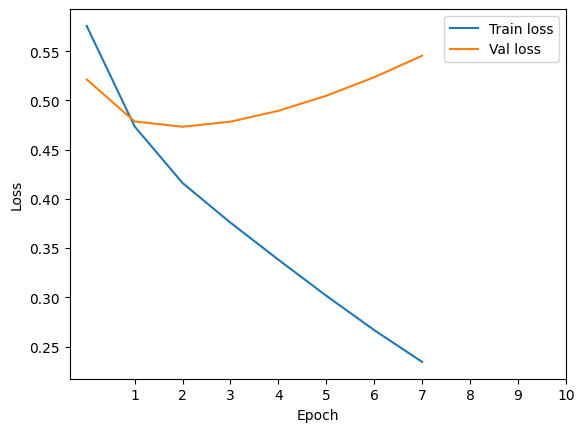

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test accuracy is 0.7688657584570642
Test precision is 0.8193404814889743
Test recall is 0.8677951574887508
Test f1 is 0.8428720083246618


In [71]:
model = Sequential()
model.add(Embedding(max_words, 25))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

test_model(model, X_train, y_train, X_test, y_test, X_val, y_val)

Модель показывает неплохое качество, при этом precision и recall довольно сбалансированы и близки друг к другу.

Попробуем далее усложнить модель.

Epoch 1/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.5968 - precision: 0.7176 - recall: 0.9932 - val_loss: 0.5142 - val_precision: 0.7705 - val_recall: 0.9377
Epoch 2/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4840 - precision: 0.7701 - recall: 0.9464 - val_loss: 0.4784 - val_precision: 0.8141 - val_recall: 0.8612
Epoch 3/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4206 - precision: 0.8219 - recall: 0.9136 - val_loss: 0.4754 - val_precision: 0.8234 - val_recall: 0.8555
Epoch 4/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3762 - precision: 0.8517 - recall: 0.9148 - val_loss: 0.4830 - val_precision: 0.8208 - val_recall: 0.8485
Epoch 5/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3337 - precision: 0.8775 - recall: 0.9224 - val_loss: 0.4976 - val_precision: 0.8170 - val_recall: 0.8480


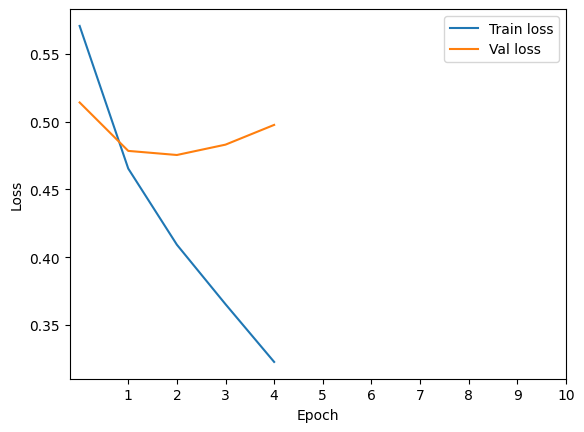

205/205 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test accuracy is 0.7557018215215062
Test precision is 0.7682096069868996
Test recall is 0.9423612599100064
Test f1 is 0.8464203233256351


In [12]:
model = Sequential()
model.add(Embedding(max_words, 30))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

test_model(model, X_train, y_train, X_test, y_test, X_val, y_val)

По чистому f1 модель становится лучше, но присутствует дисбаланс в сторону recall

Попробуем рекурентные нейросети, которые часто хорошо подходят для классификации текстов.

Epoch 1/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.6072 - precision: 0.7162 - recall: 0.9859 - val_loss: 0.5793 - val_precision: 0.7252 - val_recall: 1.0000
Epoch 2/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - loss: 0.5540 - precision: 0.7441 - recall: 0.9396 - val_loss: 0.5113 - val_precision: 0.8017 - val_recall: 0.8654
Epoch 3/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.4346 - precision: 0.8360 - recall: 0.8960 - val_loss: 0.5187 - val_precision: 0.8246 - val_recall: 0.8210
Epoch 4/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 0.3676 - precision: 0.8742 - recall: 0.9061 - val_loss: 0.5519 - val_precision: 0.8208 - val_recall: 0.8167
Epoch 5/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.3125 - precision: 0.8982 - recall: 0.9219 - val_loss: 0.6021 - val_precision: 0.8109 - val_recall: 0.8138


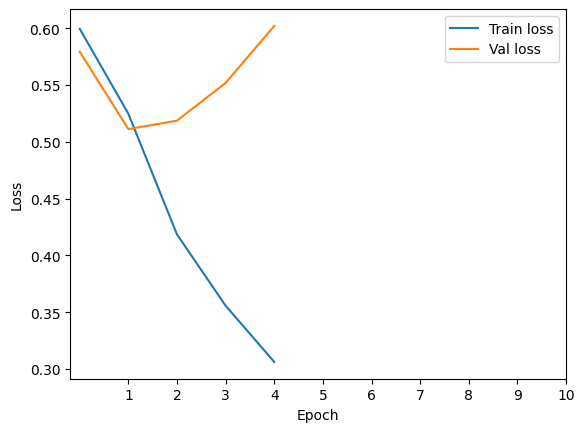

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test accuracy is 0.7143731823052196
Test precision is 0.7143731823052196
Test recall is 1.0
Test f1 is 0.8333928571428572


In [13]:
model = Sequential()
model.add(Embedding(max_words, 15))
model.add(SimpleRNN(12))
model.add(Dense(1, activation='sigmoid'))

test_model(model, X_train, y_train, X_test, y_test, X_val, y_val)

Модель переобучилась и очевидно имеем наивный прогноз (всегда 1), отсюда высокий recall и низкий precision.

Epoch 1/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 14s 12ms/step - loss: 0.6090 - precision: 0.7156 - recall: 0.9572 - val_loss: 0.5608 - val_precision: 0.7292 - val_recall: 0.9814
Epoch 2/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.5592 - precision: 0.7324 - recall: 0.9681 - val_loss: 0.5576 - val_precision: 0.7451 - val_recall: 0.9456
Epoch 3/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.5212 - precision: 0.7647 - recall: 0.9441 - val_loss: 0.5733 - val_precision: 0.7633 - val_recall: 0.8739
Epoch 4/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.4771 - precision: 0.8002 - recall: 0.9252 - val_loss: 0.5950 - val_precision: 0.7666 - val_recall: 0.8269
Epoch 5/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - loss: 0.4262 - precision: 0.8263 - recall: 0.9212 - val_loss: 0.6181 - val_precision: 0.7656 - val_recall: 0.8346


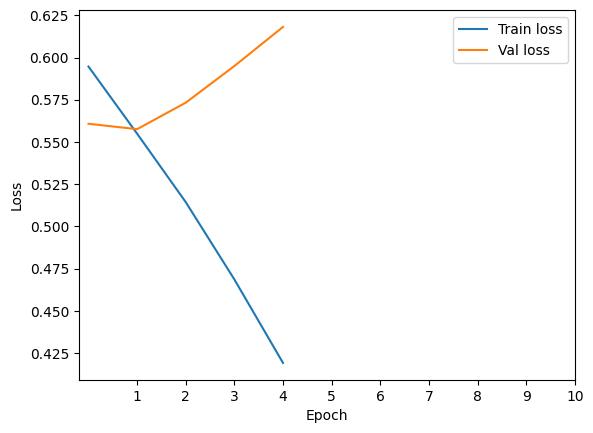

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Test accuracy is 0.7117710087249349
Test precision is 0.7190056639395846
Test recall is 0.9792157703021213
Test f1 is 0.8291753606096344


In [14]:
model = Sequential()
model.add(Embedding(max_words, 15))
model.add(SimpleRNN(12))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

test_model(model, X_train, y_train, X_test, y_test, X_val, y_val)

Дропаут слой сильно не помогает.

Epoch 1/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.6002 - precision: 0.7260 - recall: 0.9250 - val_loss: 0.4992 - val_precision: 0.7753 - val_recall: 0.9228
Epoch 2/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.4863 - precision: 0.8008 - recall: 0.9069 - val_loss: 0.4817 - val_precision: 0.8196 - val_recall: 0.8473
Epoch 3/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.4438 - precision: 0.8357 - recall: 0.8902 - val_loss: 0.4876 - val_precision: 0.8193 - val_recall: 0.8468
Epoch 4/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - loss: 0.3994 - precision: 0.8547 - recall: 0.8943 - val_loss: 0.5064 - val_precision: 0.8338 - val_recall: 0.8098
Epoch 5/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 15s 16ms/step - loss: 0.3663 - precision: 0.8738 - recall: 0.9080 - val_loss: 0.5349 - val_precision: 0.8309 - val_recall: 0.8056


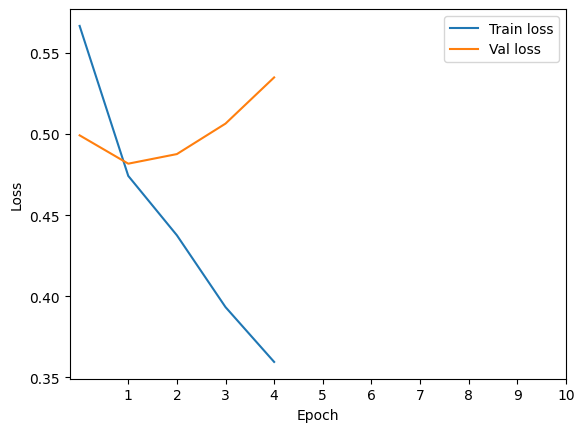

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Test accuracy is 0.7541711311801622
Test precision is 0.7730597680642284
Test recall is 0.9284336833083351
Test f1 is 0.8436526479750779


In [16]:
model = Sequential()
model.add(Embedding(max_words, 15))
model.add(SimpleRNN(12))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

test_model(model, X_train, y_train, X_test, y_test, X_val, y_val)

Попробуем модель GRU

Epoch 1/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step - loss: 0.5968 - precision: 0.7259 - recall: 0.9719 - val_loss: 0.4774 - val_precision: 0.7892 - val_recall: 0.9064
Epoch 2/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 35s 36ms/step - loss: 0.4593 - precision: 0.8123 - recall: 0.8972 - val_loss: 0.4681 - val_precision: 0.8109 - val_recall: 0.8607
Epoch 3/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 36s 36ms/step - loss: 0.4263 - precision: 0.8370 - recall: 0.8786 - val_loss: 0.4766 - val_precision: 0.8234 - val_recall: 0.8403
Epoch 4/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 28s 28ms/step - loss: 0.4079 - precision: 0.8521 - recall: 0.8802 - val_loss: 0.4886 - val_precision: 0.8234 - val_recall: 0.8304
Epoch 5/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 28s 29ms/step - loss: 0.3976 - precision: 0.8602 - recall: 0.8810 - val_loss: 0.4948 - val_precision: 0.8256 - val_recall: 0.8167
Epoch 6/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 29s 29ms/step - loss: 0.3870 - precision: 0.8651 - recall: 0.8812 - val_loss: 0.5041 - val_precision: 0.8272 -

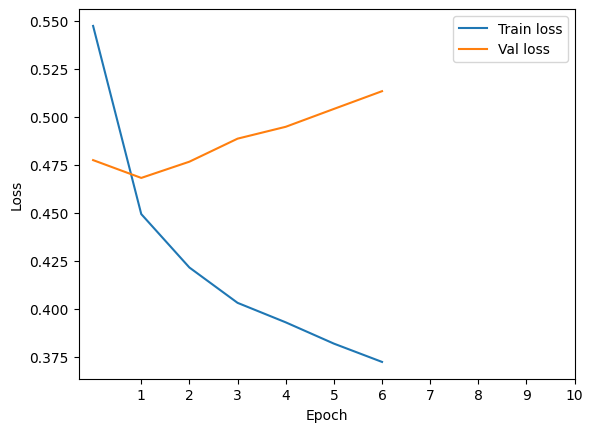

205/205 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
Test accuracy is 0.7586101331700597
Test precision is 0.8083832335329342
Test recall is 0.8677951574887508
Test f1 is 0.8370362715717681


In [17]:
model = Sequential()
model.add(Embedding(max_words, 15))
model.add(GRU(12))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

test_model(model, X_train, y_train, X_test, y_test, X_val, y_val)

Баланс precision и recall есть, но f1 ниже чем базовая простая модель.

Epoch 1/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.5936 - precision: 0.7199 - recall: 0.9789 - val_loss: 0.4797 - val_precision: 0.7725 - val_recall: 0.9362
Epoch 2/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 40s 41ms/step - loss: 0.4560 - precision: 0.7985 - recall: 0.9154 - val_loss: 0.4681 - val_precision: 0.8261 - val_recall: 0.8386
Epoch 3/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - loss: 0.4181 - precision: 0.8523 - recall: 0.8628 - val_loss: 0.4758 - val_precision: 0.8461 - val_recall: 0.7944
Epoch 4/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 46s 46ms/step - loss: 0.3998 - precision: 0.8679 - recall: 0.8586 - val_loss: 0.4868 - val_precision: 0.8483 - val_recall: 0.7820
Epoch 5/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 46s 47ms/step - loss: 0.3871 - precision: 0.8762 - recall: 0.8568 - val_loss: 0.4990 - val_precision: 0.8515 - val_recall: 0.7633
Epoch 6/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 47s 48ms/step - loss: 0.3751 - precision: 0.8839 - recall: 0.8580 - val_loss: 0.5121 - val_precision: 0.8388 -

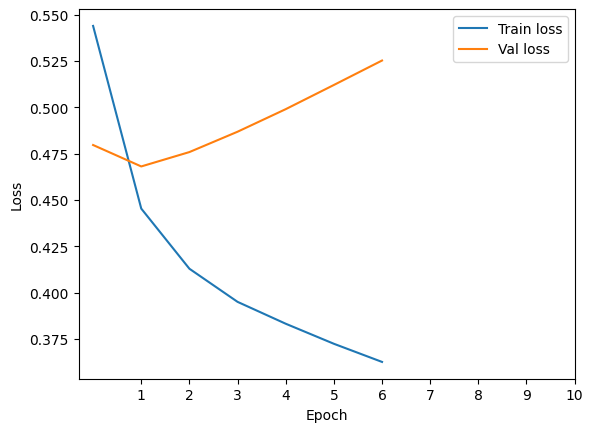

205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Test accuracy is 0.7596816164090004
Test precision is 0.821866555809603
Test recall is 0.8472251982001285
Test f1 is 0.8343532390799747


In [20]:
model = Sequential()
model.add(Embedding(max_words, 15))
model.add(LSTM(12))
model.add(Dense(1, activation='sigmoid'))

test_model(model, X_train, y_train, X_test, y_test, X_val, y_val)

Ситуация аналогична GRU

Epoch 1/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 51s 45ms/step - loss: 0.5991 - precision: 0.7201 - recall: 0.9804 - val_loss: 0.4833 - val_precision: 0.7669 - val_recall: 0.9404
Epoch 2/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - loss: 0.4585 - precision: 0.8018 - recall: 0.9101 - val_loss: 0.4737 - val_precision: 0.8199 - val_recall: 0.8525
Epoch 3/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - loss: 0.4194 - precision: 0.8479 - recall: 0.8693 - val_loss: 0.4828 - val_precision: 0.8314 - val_recall: 0.8157
Epoch 4/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 44s 45ms/step - loss: 0.4005 - precision: 0.8671 - recall: 0.8589 - val_loss: 0.4947 - val_precision: 0.8321 - val_recall: 0.8088
Epoch 5/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 45s 46ms/step - loss: 0.3881 - precision: 0.8770 - recall: 0.8590 - val_loss: 0.5063 - val_precision: 0.8362 - val_recall: 0.7934


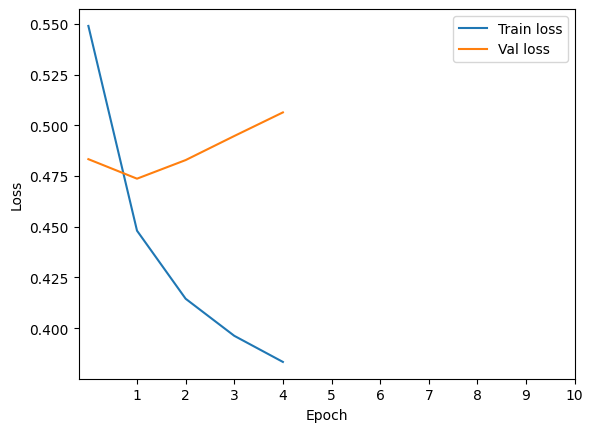

205/205 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step
Test accuracy is 0.7491198530537272
Test precision is 0.7613047980669658
Test recall is 0.9451467752303407
Test f1 is 0.843322818086225


In [25]:
model = Sequential()
model.add(Embedding(max_words, 15))
model.add(LSTM(6))
model.add(Dense(1, activation='sigmoid'))

test_model(model, X_train, y_train, X_test, y_test, X_val, y_val)

Снижение числа нейронов слоя LSTM не дает нужного эффекта, модель хуже (или нелучше) чем базовая, однако обучается дольше.

Попробуем несколько слоев LSTM

Epoch 1/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 58s 54ms/step - loss: 0.5966 - precision: 0.7209 - recall: 0.9873 - val_loss: 0.4856 - val_precision: 0.7734 - val_recall: 0.9330
Epoch 2/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 50s 50ms/step - loss: 0.4706 - precision: 0.7984 - recall: 0.9058 - val_loss: 0.4789 - val_precision: 0.8194 - val_recall: 0.8448
Epoch 3/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 96s 98ms/step - loss: 0.4322 - precision: 0.8514 - recall: 0.8548 - val_loss: 0.4864 - val_precision: 0.8311 - val_recall: 0.8088
Epoch 4/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 101s 103ms/step - loss: 0.4099 - precision: 0.8723 - recall: 0.8474 - val_loss: 0.4971 - val_precision: 0.8415 - val_recall: 0.7845
Epoch 5/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 104s 106ms/step - loss: 0.3920 - precision: 0.8850 - recall: 0.8483 - val_loss: 0.5142 - val_precision: 0.8400 - val_recall: 0.7862


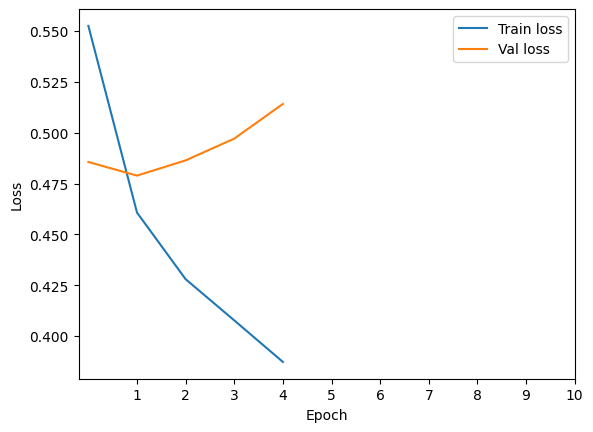

205/205 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step
Test accuracy is 0.756007959589775
Test precision is 0.7697033526417413
Test recall is 0.9395757445896722
Test f1 is 0.8461983790042454


In [237]:
model = Sequential()
model.add(Embedding(max_words, 30))
model.add(LSTM(6, return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(6))
model.add(Dropout(0.25))
model.add(Dense(1, activation='sigmoid'))

test_model(model, X_train, y_train, X_test, y_test, X_val, y_val)

Качество выросло незаметно

Попробуем полносвязную нейросеть

Epoch 1/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - loss: 0.6379 - precision: 0.7144 - recall: 0.9358 - val_loss: 0.5443 - val_precision: 0.7252 - val_recall: 1.0000
Epoch 2/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.5452 - precision: 0.7199 - recall: 0.9936 - val_loss: 0.4813 - val_precision: 0.7292 - val_recall: 0.9975
Epoch 3/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 0.4775 - precision: 0.7629 - recall: 0.9372 - val_loss: 0.4749 - val_precision: 0.8090 - val_recall: 0.8689
Epoch 4/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 0.4325 - precision: 0.7941 - recall: 0.9190 - val_loss: 0.5175 - val_precision: 0.8051 - val_recall: 0.8706
Epoch 5/10
984/984 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 0.3785 - precision: 0.8372 - recall: 0.9123 - val_loss: 0.6046 - val_precision: 0.8057 - val_recall: 0.8567


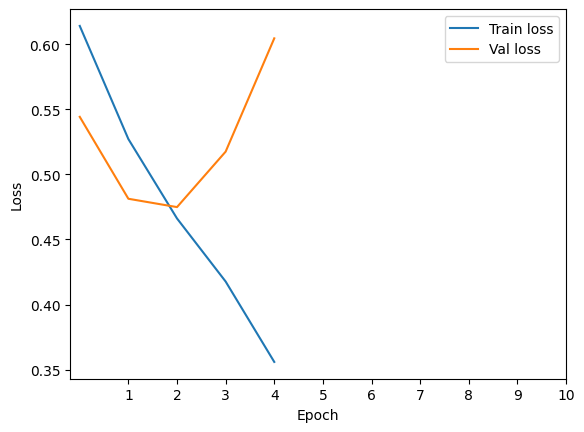

205/205 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test accuracy is 0.7143731823052196
Test precision is 0.7143731823052196
Test recall is 1.0
Test f1 is 0.8333928571428572


In [26]:
model = Sequential()
model.add(Embedding(max_words, 30))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

test_model(model, X_train, y_train, X_test, y_test, X_val, y_val)

Переобучение и наивный прогноз

Проведем кросс валидацию базовой модели.
Легко можем себе это позволить, так как модель простая и учится очень быстро.
А если можем себе позволить, то почему бы и не сделать.

In [37]:
def cross_validate(
        model, X_train, X_test,
        y_train, y_test,
        loss_function = 'binary_crossentropy', 
        threshold=0.5, no_epochs=10,
        batch_size=32, max_words=5000,
        optimizer='adam'
        
        ) -> None:

    """
    Performs 5-fold cross-validation for a classification model, using embedding for text vectorization.

    Args:
        model: The classification model to be trained.
        X_train: Array of training data (text data).
        X_test: Array of test data (text data).
        y_train: Vector of class labels for the training data.
        y_test: Vector of class labels for the test data.

    Returns:
        None. Prints the cross-validation results to the console.
    """

    # Define per-fold score containers
    f1_per_fold = []
    recall_score_per_fold = []
    precison_score_per_fold = []

    # Merge inputs and targets
    inputs = np.concatenate((X_train, X_test), axis=0)
    targets = np.concatenate((y_train, y_test), axis=0)

    # Define the K-fold Cross Validator
    kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(inputs, targets):
        tokenizer = Tokenizer(num_words=max_words)
        tokenizer.fit_on_texts(inputs[train])
        sequences_train = tokenizer.texts_to_sequences(inputs[train])
        sequences_test = tokenizer.texts_to_sequences(inputs[test])
        
        X_train = pad_sequences(sequences_train, maxlen=maxlen)
        y_train = np.array(targets[train])

        X_test = pad_sequences(sequences_test, maxlen=maxlen)
        y_test = np.array(targets[test])

        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

        # Compile the model
        model.compile(
            loss=loss_function,
            optimizer=optimizer
            )

        # Generate a print
        print('------------------------------------------------------------------------')
        print(f'Training for fold {fold_no} ...')

        model.fit(
            X_train, y_train,
            epochs=no_epochs,
            batch_size=batch_size,
            callbacks=[early_stopping],
            validation_data=(X_val, y_val),
            shuffle=False
            )

        # Generate generalization metrics
        y_pred = model.predict(X_test)
        y_pred = (y_pred > threshold).astype(int)
        
        f1_per_fold.append(f1_score(y_test, y_pred))
        precison_score_per_fold.append(precision_score(y_test, y_pred))
        recall_score_per_fold.append(recall_score(y_test, y_pred))
        
        # Increase fold number
        fold_no = fold_no + 1

    # == Provide average scores ==
    print('------------------------------------------------------------------------')
    print('Score per fold')
    for i in range(0, len(f1_per_fold)):
        print('------------------------------------------------------------------------')
        print(
            f'''
            > Fold {i+1}
            - F1: {f1_per_fold[i]}
            - Precision: {precison_score_per_fold[i]}
            - Recall: {recall_score_per_fold[i]}
            ''')
    print('------------------------------------------------------------------------')
    print('Average scores for all folds:')
    print(f'> F1: {np.mean(f1_per_fold)} (+- {np.std(f1_per_fold)})')
    print(f'> Precision: {np.mean(precison_score_per_fold)} (+- {np.std(precison_score_per_fold)})')
    print(f'> Recall: {np.mean(recall_score_per_fold)} (+- {np.std(recall_score_per_fold)})')
    print('------------------------------------------------------------------------')

In [72]:
df = pd.read_csv('data/data.csv', quotechar='"')
texts = df['text'].astype(str)
relevance = df['relevant']
X_train, X_test, y_train, y_test = train_test_split(texts, relevance, test_size=0.2, random_state=42, shuffle=True)

In [119]:
model = Sequential()
model.add(Embedding(5000, 30))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

cross_validate(
    model, X_train, X_test,
    y_train, y_test, max_words=5000
    )

model.summary()


------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5784 - val_loss: 0.4883
Epoch 2/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4396 - val_loss: 0.4832
Epoch 3/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3638 - val_loss: 0.5039
Epoch 4/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2884 - val_loss: 0.5421
Epoch 5/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2227 - val_loss: 0.5923
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5528 - val_loss: 0.5089
Epoch 2/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4430 - val_loss: 0.4913
Epoch 3/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3743 - val_loss: 0.5094
Epoch 4/10
926/926 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.3114 - val_loss

Model: "sequential_77"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_80 (Embedding)        │ (None, 100, 30)        │       150,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_62 (Flatten)            │ (None, 3000)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_79 (Dense)                │ (None, 1)              │         3,001 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 459,005 (1.75 MB)

 Trainable params: 153,001 (597.66 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 306,004 (1.17 MB)

F1 очень близок с лучшей моделью из классических, модель более менее балансирована по precision и recall. Recall выше, что отлично подходит для нашей задачи.

В итоге наилучшей моделью оказалась простая модель нейросети, состоящая из слоя эмбеддинга и выходного слоя.
Эта модель показывает очень близкое качество с моделью из файла с классическими методами, однако в случае нейросети модель обучается в разы быстрее, а значит она подходит лучше для нашей задачи.